# Allen Mouse Brain Atlas Comparison Analysis
The Allen Institue provides a genome-wide in situ hybridization (ISH) atlas for approximately 20,000 genes, where in situ hybridization was used to detect specific RNA sequences of each gene within tissue sections.
In situ hybridization whole slide images have been processed with an informatics data processing pipeline developed by the Allen Institute in order to quantify the gene expression at a grid voxel resolution level. The full expression grid is 67x41x58=159,326 voxels spanning both hemispheres and includes background voxels. More information about ISH data processing can be found here: [1].  We use this grid expression data to compare gene expression patterns of each gene targeted with ISS with the respective patterns from ISH data. In order to evalutate for pattern similarity we use the Kullback-Leibler (KL) divergence.

[1] http://help.brain-map.org/display/mousebrain/Documentation

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from skimage.transform import rotate
from scipy import sparse,stats
import os
from joblib import Parallel, delayed
import seaborn as sns

The spatial distribution of each gene targeted with ISS is compared with the gene expression spatial distributions from ISH data of all ISS targeted genes at grid resolution level. For each comparison the x,y coordinates of all the reads belonging to a given gene are scaled to match the resolution of the expression grid. And a probability density function (pdf) is estimated using a gaussian kernel with covariance factor of 0.05. The KL divergence is then computed between the normalized estimated pdf and the normalized grid expression from the ISH atlas. Normalization is achieved so that the total mass of each pdf is 1. In order to speed up the computation, the KL divergence is computed only for 2 z levels (representing the region of the ISS section in the atlas) of the grid expression atlas, one level at a time. For each gene-gene KL comparison the z level reporting the smaller distance (across all ISH samples) is then the selected.

__Run__ `queryAllenBrainAtlas` __notebook to download grid expression patterns from mouse ISH expression data before continue__.

In [4]:
def runKL(path, tags, tagList, barcodes_df, idx_i, tag_i, img_shape, hm_mat_KL, idx_mat_KL, img_mat_z, img_mat_KL, sample):
    for idx_j,tag_j in enumerate(tags):
        print(tag_i+" "+tag_j)
        if len(os.listdir(path+"/"+tag_j))>0:
            barcodes = tagList[tagList.loc[:,'gene']==tag_i].barcode.values
            x_df=barcodes_df[barcodes_df.letters.isin(barcodes)].global_X_pos
            y_df=barcodes_df[barcodes_df.letters.isin(barcodes)].global_Y_pos
            
            # Filter genes with less then 500 reads
            if len(x_df)>500:
                tmp_res_KL=[]
                for s in  range(len(os.listdir(path+"/"+tag_j))):
                    print(os.listdir(path+"/"+tag_j)[s])
                    dataset_n = os.listdir(path+"/"+tag_j)[s]
                    arr=np.load(path+"/"+tag_j+"/"+dataset_n+"/energy.npy")[38:40,:,:]
                    
                    # Scale coordinates
                    y = np.asarray(x_df)
                    x = np.asarray(y_df)
                    x=x*(arr.shape[1]/img_shape[0])
                    y=y*(arr.shape[2]/img_shape[1])
        
                    xmin = x.min()
                    xmax = x.max()
                    ymin = y.min()
                    ymax = y.max()
                    
                    # Estiamte Probability Density Function 
                    X, Y = np.mgrid[0:arr.shape[1], 0:arr.shape[2]]
                    positions = np.vstack([X.ravel(), Y.ravel()])
                    values = np.vstack([x, y])
                    kernel = stats.gaussian_kde(values, bw_method=0.05)
                    z = np.reshape(kernel(positions).T, X.shape)
                    
                    # Rotate and Normalize PDF
                    z = rotate(z,180)
                    z_pdf = z/np.sum(z)
        
                    z_mat=sparse.csr_matrix(z_pdf)
                    z_data=z_mat.data
                    z_idxs=z_mat.nonzero()
                    sig1=np.vstack((z_data,z_idxs[0],z_idxs[1])).T
        
                    res_KL=[]
                    for i in range(arr.shape[0]):
                        a=arr[i,:,:]
                        if np.amax(a)>0:
                            # remove negative values in grid
                            a[a<0]=0
                            # Normalize grid level
                            a_pdf= a/np.sum(a)
                            print(i)
                              
                            # Compute KL divergence
                            res=cv2.compareHist(z_pdf.astype(np.float32),a_pdf.astype(np.float32),cv2.HISTCMP_KL_DIV)
                            res_KL.append(res)
                            print(res)
                        else:
                            res_KL.append(np.nan)
                
                    res_KL=np.array(res_KL)
                    tmp_res_KL.append(res_KL)
                
                tmp_res_KL = np.array(tmp_res_KL)
                s_KL=np.nanargmin(np.nanmin(tmp_res_KL, axis=1))
                res_KL = tmp_res_KL[s_KL,:]
                
                hm_mat_KL[idx_i,idx_j]=np.nanmin(res_KL)
                idx_mat_KL[idx_i,idx_j]=np.nanargmin(res_KL)
                img_mat_z[idx_i,idx_j,:,:]=z_pdf
                img_mat_KL[idx_i,idx_j,:,:]=arr[int(idx_mat_KL[idx_i,idx_j]),:,:]
                sample[idx_i][idx_j] = os.listdir(path+"/"+tag_j)[s_KL]

In [ ]:
path = "../data/AllenBrainAtlas"
datasets = ['170315_161220_4_1','161230_161220_3_1']
for dataset in datasets:
    barcodes_df = pd.read_csv("../data/results/"+dataset+"/barcodes.csv", sep = ",")
    
    if dataset == '170315_161220_4_1':
        tagList = pd.read_csv('../data/tagList_99-gene.csv', sep = ",", names=['barcode','gene'])
    else:
        tagList = pd.read_csv('../data/tagList_84-gene.csv', sep = ",", names=['barcode','gene'])

    d = pd.Series(tagList.gene.values,index=tagList.barcode).to_dict()
    barcodes_df["Gene"] = barcodes_df['letters'].map(d)

    # Quality filtering
    def T_quality(x):
        return np.clip(1-np.log(1+x)/3.9,0,1)

    barcodes_df.seq_quality_min=barcodes_df.seq_quality_min*barcodes_df.max_dist.apply(T_quality)
    Q_th=2.5
    barcodes_df = barcodes_df[barcodes_df.seq_quality_min>Q_th]

    tags=tagList.gene.unique().tolist()
    
    if dataset=="170315_161220_4_1":
        img_shape = (22508, 33566)
    else:
        img_shape = (22563, 31782)
        

    hm_mat_KL = np.zeros((len(tags),len(tags)))
    idx_mat_KL = np.zeros((len(tags),len(tags)))
    img_mat_z = np.zeros((len(tags),len(tags),41,58))
    img_mat_KL = np.zeros((len(tags),len(tags),41,58))

    sample = [[None] * len(tags) for n in  range(len(tags))]
    

    res = Parallel(n_jobs=20, backend="threading")(delayed(runKL)(path, tags, tagList, barcodes_df, idx_i, tag_i, img_shape, hm_mat_KL, idx_mat_KL, img_mat_z, img_mat_KL, sample) for idx_i,tag_i in enumerate(tags))

    # Save results
    np.save("../data/results/AllenBrainAtlas/"+dataset+"/hm_mat_KL",hm_mat_KL)
    np.save("../data/results/AllenBrainAtlas/"+dataset+"/idx_mat_KL",idx_mat_KL)
    np.save("../data/results/AllenBrainAtlas/"+dataset+"/img_mat_z",img_mat_z)
    np.save("../data/results/AllenBrainAtlas/"+dataset+"/img_mat_KL",img_mat_KL)
    np.save("../data/results/AllenBrainAtlas/"+dataset+"/sample_KL",sample)

(79, 79)
(67, 67)


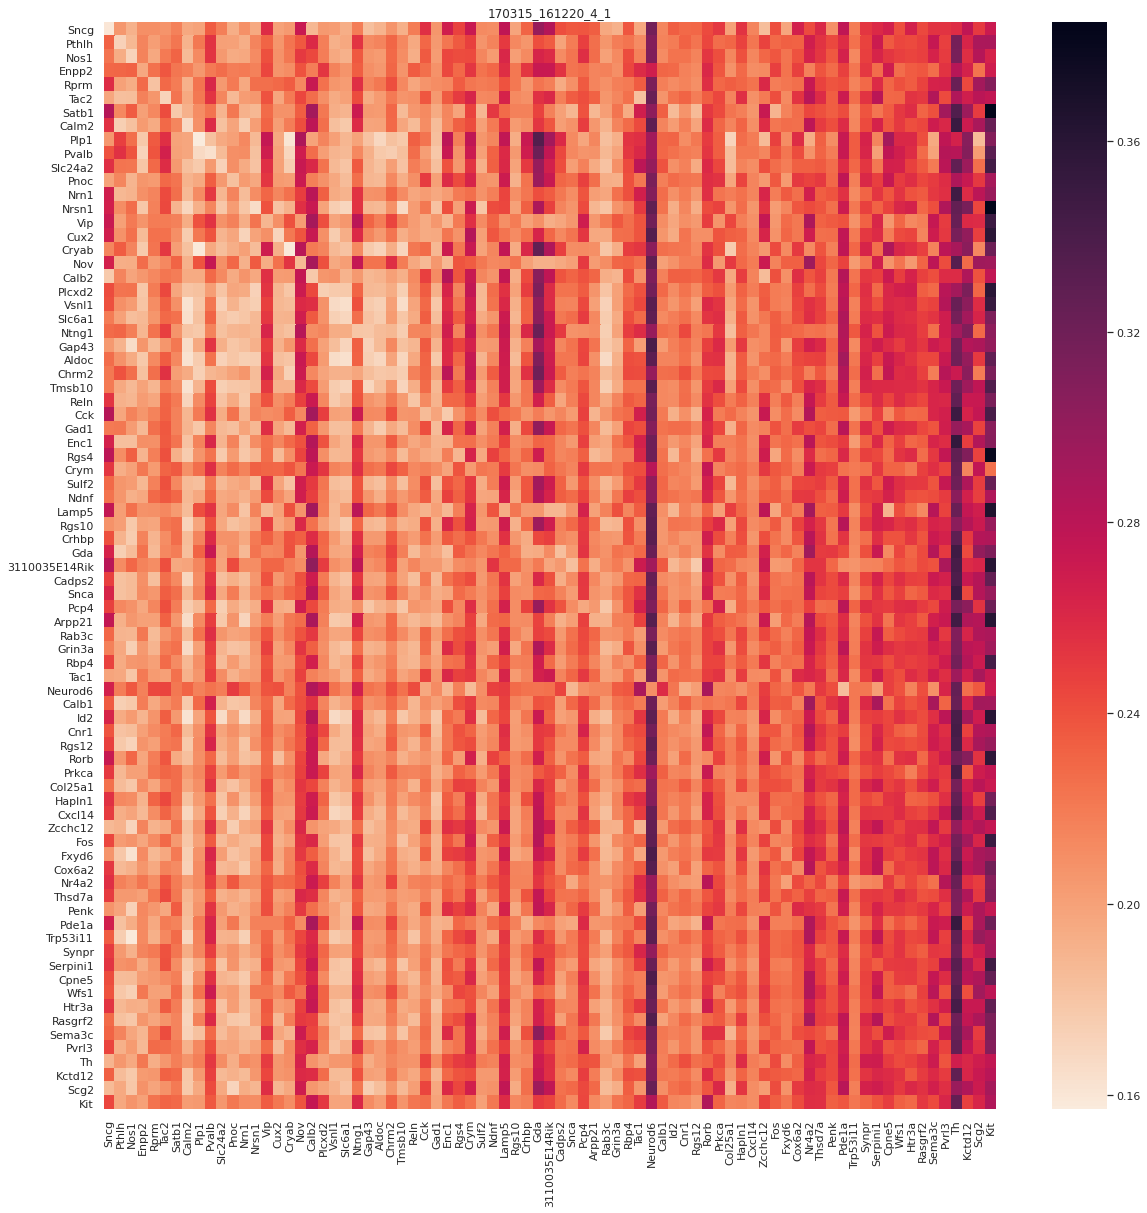

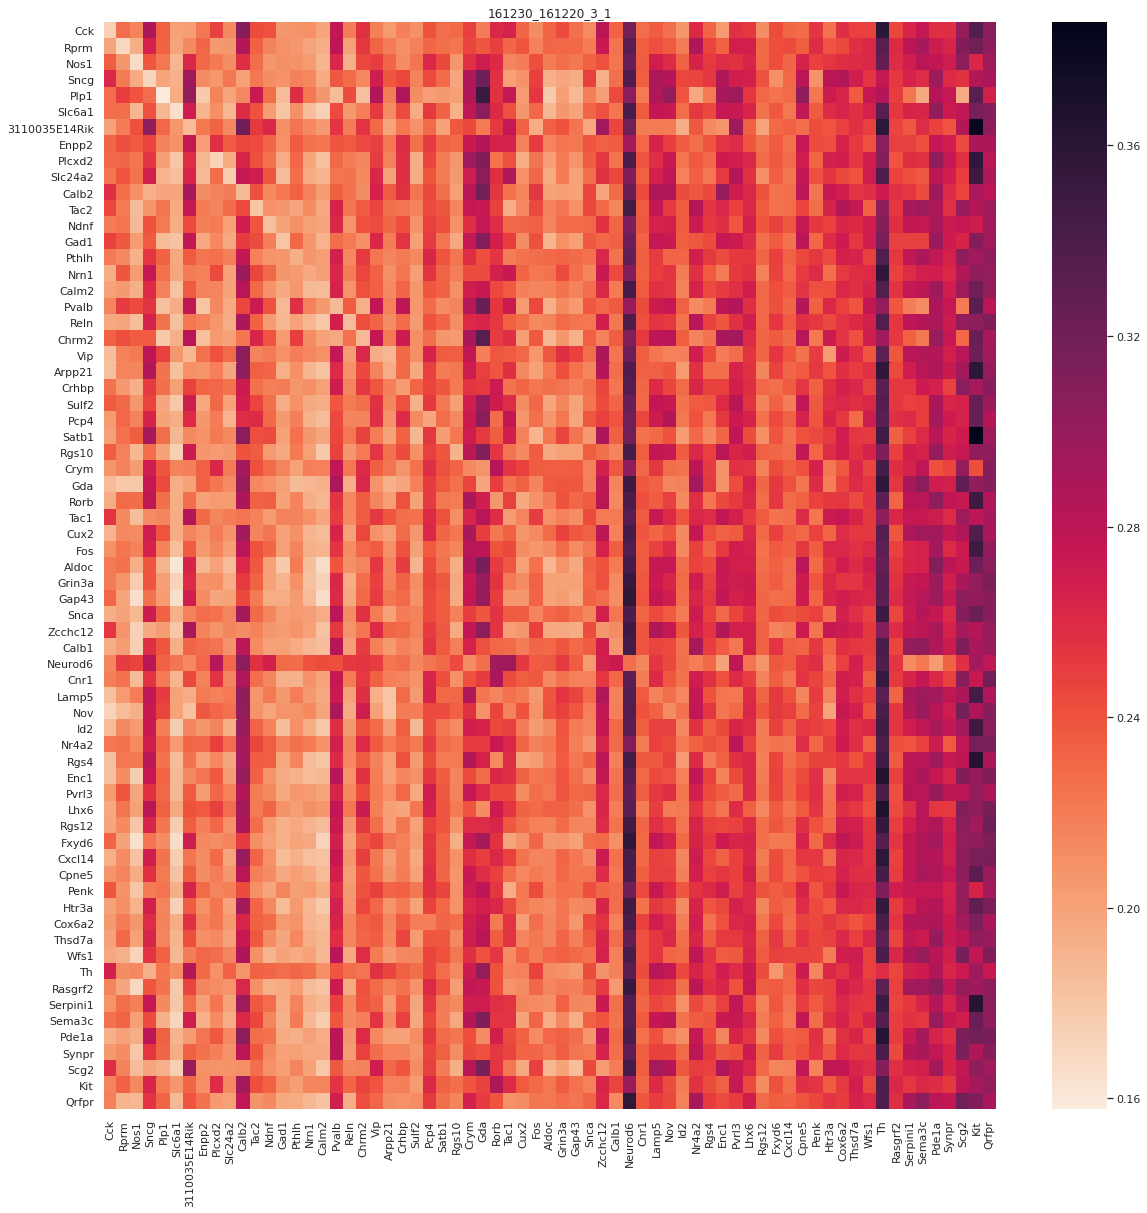

In [4]:
from sklearn.preprocessing import scale


path = "../data/results/AllenBrainAtlas"
datasets = ['170315_161220_4_1','161230_161220_3_1']
### Plot results ###
for sample in datasets:
    hm_mat_KL = np.load(path+"/"+sample+"/hm_mat_KL.npy")
    idx_mat_KL = np.load(path+"/"+sample+"/idx_mat_KL.npy")
    
    if sample == '170315_161220_4_1':
        tagList = pd.read_csv('../data/tagList_99-gene.csv', sep = ",", names=['barcode','gene'])
    else:
        tagList = pd.read_csv('../data/tagList_84-gene.csv', sep = ",", names=['barcode','gene'])

    tags=tagList.gene.unique().tolist()

    # KL
    df=pd.DataFrame(hm_mat_KL, index=tags,columns=tags)
    
    # Remove gene without ISH data
    if sample == '170315_161220_4_1':
        noISH = ['Gabrd', 'Adgrl2', 'Npy2r', 'Cplx2', 'Fam19a1', 'Chodl', 'Bcl11b', 'Cdh13', 'Atp1b1', '6330403K07Rik']
    else:
        noISH = ['Gabrd', 'Adgrl2', 'Npy2r', 'Fam19a1', 'Chodl', 'Bcl11b', 'Cdh13', 'Atp1b1']
    df.drop(noISH,axis=0, inplace=True)
    df.drop(noISH,axis=1, inplace=True)
    
    # Remove genes with less than 500 reads (0 values)
    lowcount_genes = df.loc[(df==0).all(axis=1)].index


    col = []
    for i in df.columns:   
        if not i in lowcount_genes:
            col.append(i) 

    df = df.reindex(col, axis=0)   
    df = df.reindex(col, axis=1)
    
    #df=df/df.sum(axis=0)[None,:]
    df=df/df.sum(axis=1)[:,None]
    #df=(df-df.min(axis=1))/(df.max(axis=1)-df.min(axis=1))[:,None]
    #df=(df-df.min(axis=0))/(df.max(axis=0)-df.min(axis=0))[None,:]

    # Sorting row genes by highest difference between gene-gene and gene-others distances
    C = []
    for idx, row in df.iterrows():
        C.append(row[~(row.index==row.name)].min() - row[(row.index==row.name)].values[0])
    C = pd.DataFrame(C, index=df.index, columns=['C'])
    C = C.sort_values(['C'],axis=0, ascending=False)

    df = df.reindex(C.index, axis=0)   
    df = df.reindex(C.index, axis=1)
    
    print(df.shape)

    # Plot heatmap
    plt.figure(figsize=(20,20))
    plt.title(sample)
    sns.set(font_scale=1)
    g = sns.heatmap(df**0.333,annot=False,xticklabels=True, yticklabels=True, cmap=sns.cm.rocket_r)